In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import warnings
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

from pdpbox import pdp, info_plots
from pdpbox import pdp, info_plots

sns.set()

In [2]:
access_gare_metro = pd.read_csv('accessibilite-des-gares-et-stations-metro-et-rer-ratp.csv',sep=';')
access_bus = pd.read_csv('accessibilite-des-arrets-de-bus-ratp.csv', sep=';')
access_ligne = pd.read_csv('accessibilite-des-lignes-du-reseau-de-surface-ratp.csv', sep=';')

In [3]:
def compute_metrics(model, x_test=None, y_test=None, verbose=True):
    """
    Computes 3 accuracy metrics.
    model : Model to compute metrics with.
    x_test : Custom test set.
    y_test : Custom ground truth values.
    """
    if x_test is None and y_test is None:
        x_test = X_test
        y_test = Y_test
    Y_pred = model.predict(x_test)
    #fpr, tpr, _ = roc_curve(y_test.values, model.predict_proba(x_test)[:,1])
    dict_out = {
        'Mean Absolute Error':mean_absolute_error(y_test, Y_pred),
        'Mean Squared Error':mean_squared_error(y_test, Y_pred, squared=False),
        'R2':r2_score(y_test, Y_pred)
    }
    if verbose:
        print("Metrics :", dict_out)
    return dict_out


In [4]:
def grid_tuning(instance, grid):
    cv = GridSearchCV(instance, grid, n_jobs=1, refit=True,
                   verbose=0, cv=2, return_train_score=True)
    cv.fit(X_train, Y_train)
    print("Best parameters :", cv.best_params_)
    return cv


## Accessibilité Metro RER Gare

In [5]:
access_gare_metro

,idptar,nomptar,STIF,CodeINSEE,X,Y,coord,UFR,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,PAQT,Accessibilite Quai Train,IDAMIVIF
0,1832,Nation,1.001100e+12,75112.0,604516.0,2427753.0,"48.8481111908,2.39800400946",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
1,1642,Saint-Paul (Le Marais),1.001100e+12,75104.0,601823.0,2428533.0,"48.8551344775,2.36133433573",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
2,2083,Champs-Elysées-Clémenceau,1.001100e+12,75108.0,598357.0,2429936.0,"48.8677439853,2.31412277704",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
3,1961,George V,1.001100e+12,75108.0,597377.0,2430415.0,"48.8720455787,2.30076918231",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
4,2028,Charles de Gaulle-Etoile,1.001100e+12,75108.0,596963.0,2430625.0,"48.8739310535,2.29512724832",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,5005530,Les Boullereaux Champigny,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,IDAMIVIF
2333,5740949,Rosa Parks,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,IDAMIVIF
2334,5005534,Les Yvris Noisy-le-Grand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IDAMIVIF
2335,5740952,Gare de l'Est,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,IDAMIVIF


In [6]:
access_gare_metro.isna().sum()

idptar                                       0
nomptar                                      0
STIF                                      1382
CodeINSEE                                 1382
X                                         1382
Y                                         1382
coord                                     1382
UFR                                        884
Annonce Sonore Prochain Passage           1382
Annonce Visuelle Prochain Passage         1382
Annonce Sonore Situations Perturbees      1382
Annonce Visuelle Situations Perturbees    1382
PAQT                                      1382
Accessibilite Quai Train                  1382
IDAMIVIF                                     0
dtype: int64

In [7]:
access_gare_metro = access_gare_metro.drop(access_gare_metro[access_gare_metro['X'].isnull()].index)

In [8]:
access_gare_metro.isna().sum()

idptar                                    0
nomptar                                   0
STIF                                      0
CodeINSEE                                 0
X                                         0
Y                                         0
coord                                     0
UFR                                       0
Annonce Sonore Prochain Passage           0
Annonce Visuelle Prochain Passage         0
Annonce Sonore Situations Perturbees      0
Annonce Visuelle Situations Perturbees    0
PAQT                                      0
Accessibilite Quai Train                  0
IDAMIVIF                                  0
dtype: int64

In [9]:
access_gare_metro

,idptar,nomptar,STIF,CodeINSEE,X,Y,coord,UFR,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,PAQT,Accessibilite Quai Train,IDAMIVIF
0,1832,Nation,1.001100e+12,75112.0,604516.0,2427753.0,"48.8481111908,2.39800400946",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
1,1642,Saint-Paul (Le Marais),1.001100e+12,75104.0,601823.0,2428533.0,"48.8551344775,2.36133433573",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
2,2083,Champs-Elysées-Clémenceau,1.001100e+12,75108.0,598357.0,2429936.0,"48.8677439853,2.31412277704",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
3,1961,George V,1.001100e+12,75108.0,597377.0,2430415.0,"48.8720455787,2.30076918231",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
4,2028,Charles de Gaulle-Etoile,1.001100e+12,75108.0,596963.0,2430625.0,"48.8739310535,2.29512724832",0.0,1.0,1.0,1.0,1.0,0.0,0.0,IDAMIVIF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,2108,Bagneux,1.001110e+12,94016.0,598884.0,2421648.0,"48.7932557555,2.32132499298",1.0,0.0,1.0,1.0,1.0,1.0,4.0,IDAMIVIF
1771,2450,Robinson,1.001110e+12,92071.0,595923.0,2420178.0,"48.7800312802,2.28105937514",1.0,0.0,1.0,1.0,1.0,1.0,4.0,IDAMIVIF
1773,2095,Antony,1.001110e+12,92002.0,597378.0,2417373.0,"48.7548274442,2.30086506726",1.0,0.0,1.0,1.0,1.0,1.0,4.0,IDAMIVIF
1775,2348,Massy-Palaiseau,1.001110e+12,91377.0,594320.0,2413962.0,"48.7241484853,2.25934234562",1.0,0.0,1.0,1.0,1.0,1.0,4.0,IDAMIVIF


In [10]:
access_gare_metro.describe()

,idptar,STIF,CodeINSEE,X,Y,UFR,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,PAQT,Accessibilite Quai Train
count,9.550000e+02,9.550000e+02,955.000000,955.000000,9.550000e+02,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000
mean,3.363420e+05,1.001102e+12,79837.059686,600603.493194,2.428900e+06,0.216754,0.775916,0.976963,0.976963,0.976963,0.178010,0.770681
std,9.903532e+05,3.926616e+06,7792.494708,6530.091866,5.161223e+03,0.412249,0.417196,0.150098,0.150098,0.150098,0.382722,1.538050
min,1.628000e+03,1.001100e+12,75101.000000,576282.000000,2.410739e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.889500e+03,1.001100e+12,75109.000000,598092.000000,2.427078e+06,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,2.162000e+03,1.001100e+12,75115.000000,600574.000000,2.429183e+06,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,2.430500e+03,1.001100e+12,91272.000000,602910.000000,2.431169e+06,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,6.129305e+06,1.001110e+12,95527.000000,632720.000000,2.450233e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [11]:
col=['UFR','Annonce Sonore Prochain Passage','Annonce Visuelle Situations Perturbees']

In [12]:
def preprocess(dataset):
    X = pd.DataFrame()
    X = dataset[col]
    #X=dataset['Type_Jour']
    
    Y = dataset['Accessibilite Quai Train']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    #X['Sens'] = label_encoder.fit_transform(dataset['Sens'])
    #X['Doublon'] = label_encoder.fit_transform(dataset['Doublon'])
    


    return X, Y

In [13]:
processed_dataset = preprocess(access_gare_metro)
processed_dataset
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.5, shuffle=True)

Text(0.5, 1.0, 'Correlation Heatmap')

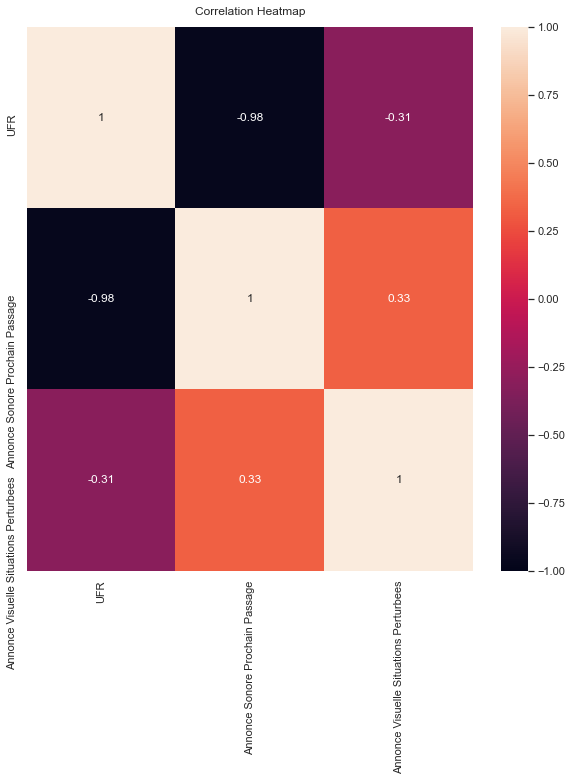

In [14]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


In [15]:
models={}

In [16]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)


RandomForestRegressor(max_depth=3, n_estimators=10, random_state=False,
                      verbose=False)

In [17]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)


[19:16:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=False,
              verbosity=None)

In [19]:
models={}
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)

Metrics : {'Mean Absolute Error': 0.0977094056895076, 'Mean Squared Error': 0.3522084118215888, 'R2': 0.9497795559901925}
Metrics : {'Mean Absolute Error': 0.043933054393305436, 'Mean Squared Error': 0.363041544702416, 'R2': 0.946642711345467}


In [20]:
results = pd.DataFrame(models).transpose()
results

,Mean Absolute Error,Mean Squared Error,R2
Random Forest,0.097709,0.352208,0.949780
Extreme Gradient Boosting,0.043933,0.363042,0.946643


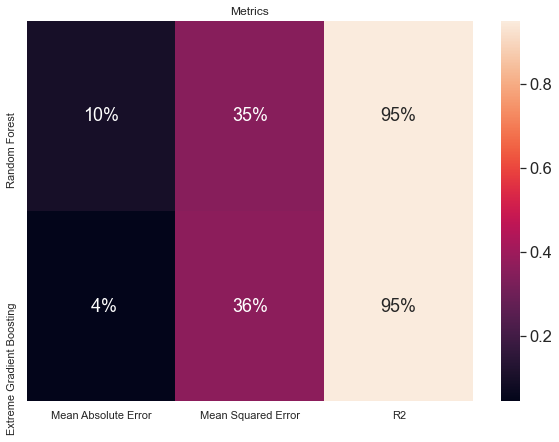

In [21]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [54]:
models

{'Random Forest': {'Mean Absolute Error': 11827.570140707568,
  'Mean Squared Error': 18876.678281565833,
  'R2': 0.1213555465961772},
 'Extreme Gradient Boosting': {'Mean Absolute Error': 0.043933054393305436,
  'Mean Squared Error': 0.363041544702416,
  'R2': 0.946642711345467}}

In [22]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 30
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

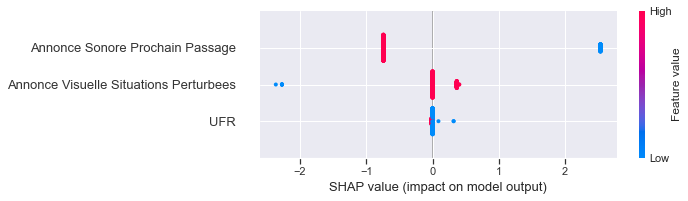

In [23]:
shap.summary_plot(shap_values, X_test)

## Accessibilité Bus

In [24]:
access_bus

,idptar,X,Y,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,coord,IDAMIVIF,nomptar,CODEINSEE,Accessibilité UFR,PAQT,IDFM,Sens,Doublon,Ligne,GIPA
0,3730068,602830,2417136,1,1,1,1,"48.7526968316,2.37497488989",IDAMIVIF,ALOUETTES,94073,1.0,NaN,100100014,R,Ok,14.0,14046
1,3730089,607960,2420329,1,1,1,1,"48.781353145,2.44476562738",IDAMIVIF,BASE DE LOISIRS DE CRETEIL,94028,1.0,NaN,100100014,R,Ok,14.0,14077
2,3730079,605354,2418603,1,1,1,1,"48.7658665727,2.40930156038",IDAMIVIF,CHOISY-LE-ROI RER,94022,1.0,NaN,100100014,R,Ok,14.0,8943
3,3730094,608518,2421285,1,1,1,1,"48.7899385073,2.45237366902",IDAMIVIF,CRETEIL - UNIVERSITE-METRO,94028,1.0,NaN,100100014,R,Ok,14.0,14074
4,3730096,609096,2421667,1,1,1,1,"48.7933640124,2.46024410349",IDAMIVIF,EGLISE DE CRETEIL,94028,1.0,NaN,100100014,R,Ok,14.0,8423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25603,7568959,604899,2431682,1,0,1,0,"48.8834197642,2.40326458876",IDAMIVIF,MARCHE - MAIRIE,93061,1.0,NaN,100100573,A,Ok,573.0,100000
25604,7568962,604797,2431214,1,0,1,0,"48.8792144936,2.40186937722",IDAMIVIF,HOPITAL ROBERT DEBRE 2,75119,1.0,NaN,100100573,A,Ok,573.0,100003
25605,7568973,605288,2431371,1,0,1,0,"48.8806216776,2.408561702",IDAMIVIF,JEAN JAURES-BELVEDERE.,93061,1.0,NaN,100100573,A,Ok,573.0,100010
25606,7568980,604998,2432235,1,0,1,0,"48.8883889391,2.40462013482",IDAMIVIF,RUE GUTENBERG - BAUDIN,93061,1.0,NaN,100100573,A,Ok,573.0,100015


In [25]:
access_bus.isna().sum()

idptar                                        0
X                                             0
Y                                             0
Annonce Sonore Prochain Passage               0
Annonce Visuelle Prochain Passage             0
Annonce Sonore Situations Perturbees          0
Annonce Visuelle Situations Perturbees        0
coord                                         0
IDAMIVIF                                      0
nomptar                                       0
CODEINSEE                                     0
Accessibilité UFR                            12
PAQT                                      25608
IDFM                                          0
Sens                                         51
Doublon                                   11309
Ligne                                       501
GIPA                                          0
dtype: int64

In [26]:
del access_bus['PAQT']

In [27]:
access_bus.describe(include='all')

,idptar,X,Y,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,coord,IDAMIVIF,nomptar,CODEINSEE,Accessibilité UFR,IDFM,Sens,Doublon,Ligne,GIPA
count,2.560800e+04,2.560800e+04,2.560800e+04,25608.000000,25608.000000,25608.000000,25608.000000,25608,25608,25608,25608.000000,25596.000000,2.560800e+04,25557,14299,25107.000000,25608.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11749,1,5044,NaN,NaN,NaN,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.8839690542,2.23464114292",IDAMIVIF,GABRIEL PERI,NaN,NaN,NaN,A,Ok,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,25608,75,NaN,NaN,NaN,13246,14101,NaN,NaN
mean,5.727976e+06,6.122606e+05,2.420935e+06,0.999492,0.326851,0.999492,0.323336,NaN,NaN,NaN,91251.683068,0.748515,7.291968e+09,NaN,NaN,309.148723,14504.954350
std,1.742907e+06,1.369553e+05,1.343130e+05,0.022526,0.469071,0.022526,0.467759,NaN,NaN,NaN,39054.870059,0.433875,8.453864e+10,NaN,NaN,235.653253,19633.990547
min,5.958250e+05,5.823450e+05,7.510400e+04,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,75101.000000,0.000000,1.001000e+08,NaN,NaN,14.000000,4.000000
25%,4.024186e+06,5.964710e+05,2.423948e+06,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,77479.000000,0.000000,1.001001e+08,NaN,NaN,124.000000,3497.000000
50%,5.221788e+06,6.012175e+05,2.428792e+06,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,92062.000000,1.000000,1.001002e+08,NaN,NaN,235.000000,7055.000000
75%,7.676409e+06,6.071195e+05,2.433287e+06,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,93073.000000,1.000000,1.001005e+08,NaN,NaN,421.000000,15103.000000


In [28]:
access_bus.Doublon.unique()

array(['Ok', nan, 'OK'], dtype=object)

In [29]:
access_bus['Doublon'].value_counts()

Ok    14101
OK      198
Name: Doublon, dtype: int64

In [30]:
access_bus['Doublon'].mask(access_bus['Doublon'] == 'OK', 'Ok' , inplace=True)

In [31]:
val_bus={'Accessibilité UFR':0,
        'Sens':'R',
        'Doublon':'Ko',
        'Ligne':0}

In [32]:
access_bus = access_bus.fillna(value=val_bus)

In [33]:
access_bus.describe(include='all')

,idptar,X,Y,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,coord,IDAMIVIF,nomptar,CODEINSEE,Accessibilité UFR,IDFM,Sens,Doublon,Ligne,GIPA
count,2.560800e+04,2.560800e+04,2.560800e+04,25608.000000,25608.000000,25608.000000,25608.000000,25608,25608,25608,25608.000000,25608.000000,2.560800e+04,25608,25608,25608.000000,25608.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11749,1,5044,NaN,NaN,NaN,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.8839690542,2.23464114292",IDAMIVIF,GABRIEL PERI,NaN,NaN,NaN,A,Ok,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,25608,75,NaN,NaN,NaN,13246,14299,NaN,NaN
mean,5.727976e+06,6.122606e+05,2.420935e+06,0.999492,0.326851,0.999492,0.323336,NaN,NaN,NaN,91251.683068,0.748165,7.291968e+09,NaN,NaN,303.100476,14504.954350
std,1.742907e+06,1.369553e+05,1.343130e+05,0.022526,0.469071,0.022526,0.467759,NaN,NaN,NaN,39054.870059,0.434076,8.453864e+10,NaN,NaN,237.232509,19633.990547
min,5.958250e+05,5.823450e+05,7.510400e+04,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,75101.000000,0.000000,1.001000e+08,NaN,NaN,0.000000,4.000000
25%,4.024186e+06,5.964710e+05,2.423948e+06,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,77479.000000,0.000000,1.001001e+08,NaN,NaN,119.000000,3497.000000
50%,5.221788e+06,6.012175e+05,2.428792e+06,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,92062.000000,1.000000,1.001002e+08,NaN,NaN,220.000000,7055.000000
75%,7.676409e+06,6.071195e+05,2.433287e+06,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,93073.000000,1.000000,1.001005e+08,NaN,NaN,396.000000,15103.000000


In [34]:
access_bus['score']=""

for i in access_bus.index:
    a=0
    if access_bus['Annonce Sonore Prochain Passage'][i] != 0 :
        a=a+1
    if access_bus['Annonce Visuelle Prochain Passage'][i] != 0 :
        a=a+1
    if access_bus['Annonce Sonore Situations Perturbees'][i] != 0 :
        a=a+1
    if access_bus['Annonce Visuelle Situations Perturbees'][i] != 0 :
        a=a+1
    if access_bus['Accessibilité UFR'][i] != 0 :
        a=a+1
    
    access_bus['score'][i]=a

In [35]:
access_bus

,idptar,X,Y,Annonce Sonore Prochain Passage,Annonce Visuelle Prochain Passage,Annonce Sonore Situations Perturbees,Annonce Visuelle Situations Perturbees,coord,IDAMIVIF,nomptar,CODEINSEE,Accessibilité UFR,IDFM,Sens,Doublon,Ligne,GIPA,score
0,3730068,602830,2417136,1,1,1,1,"48.7526968316,2.37497488989",IDAMIVIF,ALOUETTES,94073,1.0,100100014,R,Ok,14.0,14046,5
1,3730089,607960,2420329,1,1,1,1,"48.781353145,2.44476562738",IDAMIVIF,BASE DE LOISIRS DE CRETEIL,94028,1.0,100100014,R,Ok,14.0,14077,5
2,3730079,605354,2418603,1,1,1,1,"48.7658665727,2.40930156038",IDAMIVIF,CHOISY-LE-ROI RER,94022,1.0,100100014,R,Ok,14.0,8943,5
3,3730094,608518,2421285,1,1,1,1,"48.7899385073,2.45237366902",IDAMIVIF,CRETEIL - UNIVERSITE-METRO,94028,1.0,100100014,R,Ok,14.0,14074,5
4,3730096,609096,2421667,1,1,1,1,"48.7933640124,2.46024410349",IDAMIVIF,EGLISE DE CRETEIL,94028,1.0,100100014,R,Ok,14.0,8423,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25603,7568959,604899,2431682,1,0,1,0,"48.8834197642,2.40326458876",IDAMIVIF,MARCHE - MAIRIE,93061,1.0,100100573,A,Ok,573.0,100000,3
25604,7568962,604797,2431214,1,0,1,0,"48.8792144936,2.40186937722",IDAMIVIF,HOPITAL ROBERT DEBRE 2,75119,1.0,100100573,A,Ok,573.0,100003,3
25605,7568973,605288,2431371,1,0,1,0,"48.8806216776,2.408561702",IDAMIVIF,JEAN JAURES-BELVEDERE.,93061,1.0,100100573,A,Ok,573.0,100010,3
25606,7568980,604998,2432235,1,0,1,0,"48.8883889391,2.40462013482",IDAMIVIF,RUE GUTENBERG - BAUDIN,93061,1.0,100100573,A,Ok,573.0,100015,3


In [36]:
col=['Annonce Sonore Prochain Passage','Annonce Visuelle Prochain Passage',
     'Accessibilité UFR','Sens','Doublon','Ligne']

In [37]:
def preprocess(dataset):
    X = pd.DataFrame()
    X = dataset[col]
    #X=dataset['Type_Jour']
    
    Y = dataset['GIPA']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    X['Sens'] = label_encoder.fit_transform(dataset['Sens'])
    X['Doublon'] = label_encoder.fit_transform(dataset['Doublon'])
    


    return X, Y

In [38]:
processed_dataset = preprocess(access_bus)
processed_dataset
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.5, shuffle=True)

Text(0.5, 1.0, 'Correlation Heatmap')

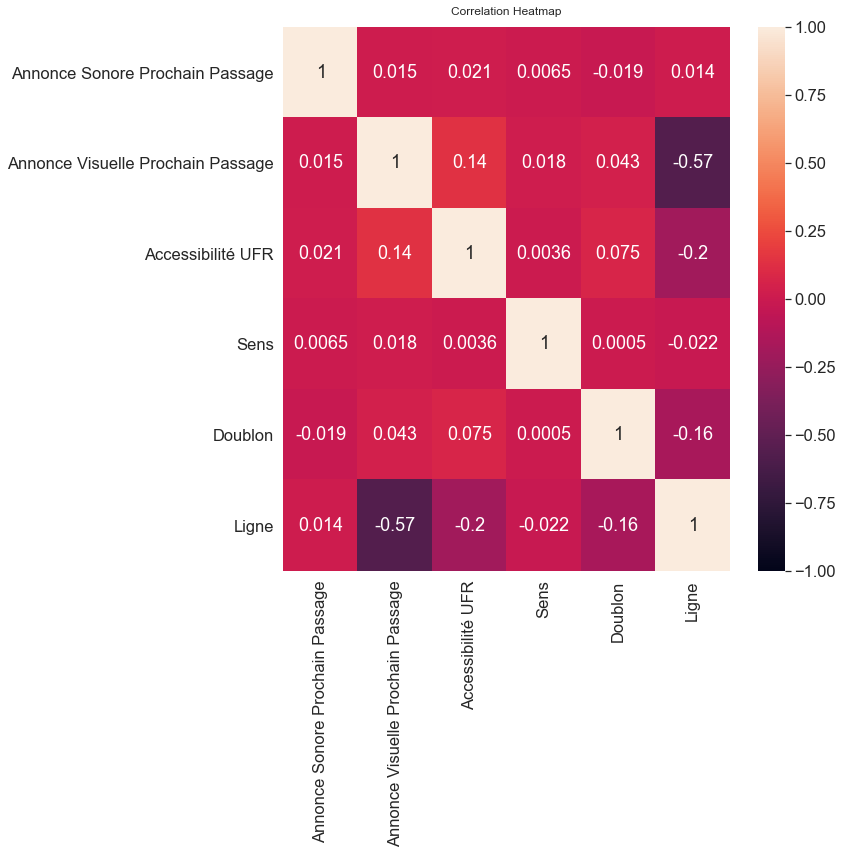

In [39]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


In [40]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)
models['Random Forest'] = compute_metrics(rfr)


Metrics : {'Mean Absolute Error': 11827.570140707568, 'Mean Squared Error': 18876.678281565833, 'R2': 0.1213555465961772}


In [ ]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)

In [ ]:
models=[]
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)

In [ ]:
results = pd.DataFrame(models).transpose()
results

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [ ]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 30
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

In [ ]:
shap.summary_plot(shap_values, X_test)

## Accessibilité Ligne

In [41]:
access_ligne

,Code STIF,Nom de Ligne,Origine,Destination,Accessibilité UFR,Rampe,Annonce sonore prochain arrêt,Annonce visuelle prochain arrêt
0,1001000240001,24,PANTHEON,ECOLE VETERINAIRE DE MAISONS-ALFORT,1,1,1,1
1,1001000260001,26,GARE SAINT-LAZARE,NATION - TRONE,1,1,1,1
2,1001000350001,35,MAIRIE D'AUBERVILLIERS,GARE DE L'EST.,1,1,1,1
3,1001000380001,38,PORTE DE LA CHAPELLE,PORTE D'ORLEANS,1,1,1,1
4,1001000400001,40,MAIRIE DU 18E - JULES JOFFRIN,LE PELETIER,1,1,1,1
...,...,...,...,...,...,...,...,...
368,1001120110001,T1,QUATRE ROUTES,NOISY-LE-SEC RER,1,0,1,0
369,1001100040001,4,PORTE DE CLIGNANCOURT,PORTE D'ORLÉANS,0,0,0,0
370,1001100110001,11,CHÂTELET,MAIRIE DES LILAS,0,0,0,0
371,1001100130001,13,SAINT-DENIS - UNIVERSITÉ • ASNIÈRES - GENNEVIL...,CHÂTILLON - MONTROUGE,0,0,0,0


In [42]:
access_ligne.isna().sum()

Code STIF                          0
Nom de Ligne                       0
Origine                            0
Destination                        0
Accessibilité UFR                  0
Rampe                              0
Annonce sonore prochain arrêt      0
Annonce visuelle prochain arrêt    0
dtype: int64

In [43]:
col=['Nom de Ligne','Origine','Destination','Rampe','Annonce sonore prochain arrêt','Annonce visuelle prochain arrêt']

In [48]:
def preprocess(dataset):
    X = pd.DataFrame()
    X = dataset[col]
    #X=dataset['Type_Jour']
    
    Y = dataset['Accessibilité UFR']

    # Label encoding for categorical variables
    label_encoder = LabelEncoder()

    X['Nom de Ligne'] = label_encoder.fit_transform(dataset['Nom de Ligne'])
    X['Origine'] = label_encoder.fit_transform(dataset['Origine'])
    X['Destination'] = label_encoder.fit_transform(dataset['Destination'])
    #X['Doublon'] = label_encoder.fit_transform(dataset['Doublon'])
    


    return X, Y

In [49]:
processed_dataset = preprocess(access_ligne)
processed_dataset
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.5, shuffle=True)

Text(0.5, 1.0, 'Correlation Heatmap')

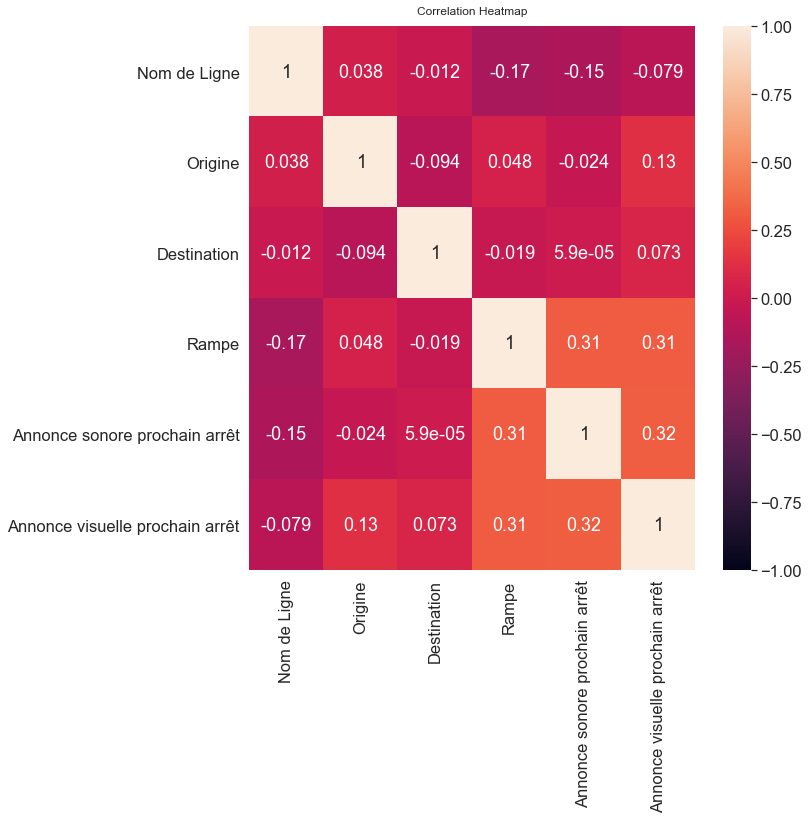

In [50]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


In [ ]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train)

In [ ]:
gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
booster = xgb.XGBClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], verbose=False)
scores = cross_val_score(booster, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
booster.fit(X_train, Y_train)

In [ ]:
models={}
models['Random Forest'] = compute_metrics(rfr)
models['Extreme Gradient Boosting'] = compute_metrics(booster)


In [ ]:
results = pd.DataFrame(models).transpose()
results

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

In [51]:
shap.initjs()
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)
booster = model.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 30
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

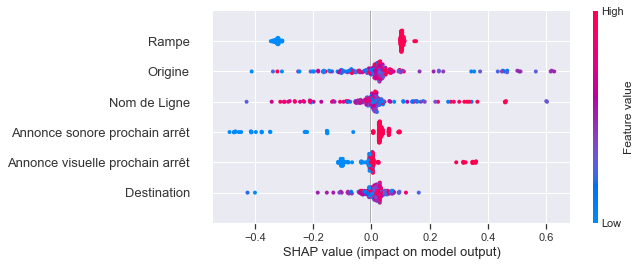

In [52]:
shap.summary_plot(shap_values, X_test)